## Import Libraries and Load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import warnings

# Hide warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('cia_factbook.csv')

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  259 non-null    object 
 1   area                     257 non-null    float64
 2   birth_rate               224 non-null    float64
 3   death_rate               225 non-null    float64
 4   infant_mortality_rate    224 non-null    float64
 5   internet_users           213 non-null    float64
 6   life_exp_at_birth        224 non-null    float64
 7   maternal_mortality_rate  184 non-null    float64
 8   net_migration_rate       222 non-null    float64
 9   population               238 non-null    float64
 10  population_growth_rate   233 non-null    float64
dtypes: float64(10), object(1)
memory usage: 22.4+ KB
None
         country        area  birth_rate  death_rate  infant_mortality_rate  \
0         Russia  17098242.0       11.87       13.83   

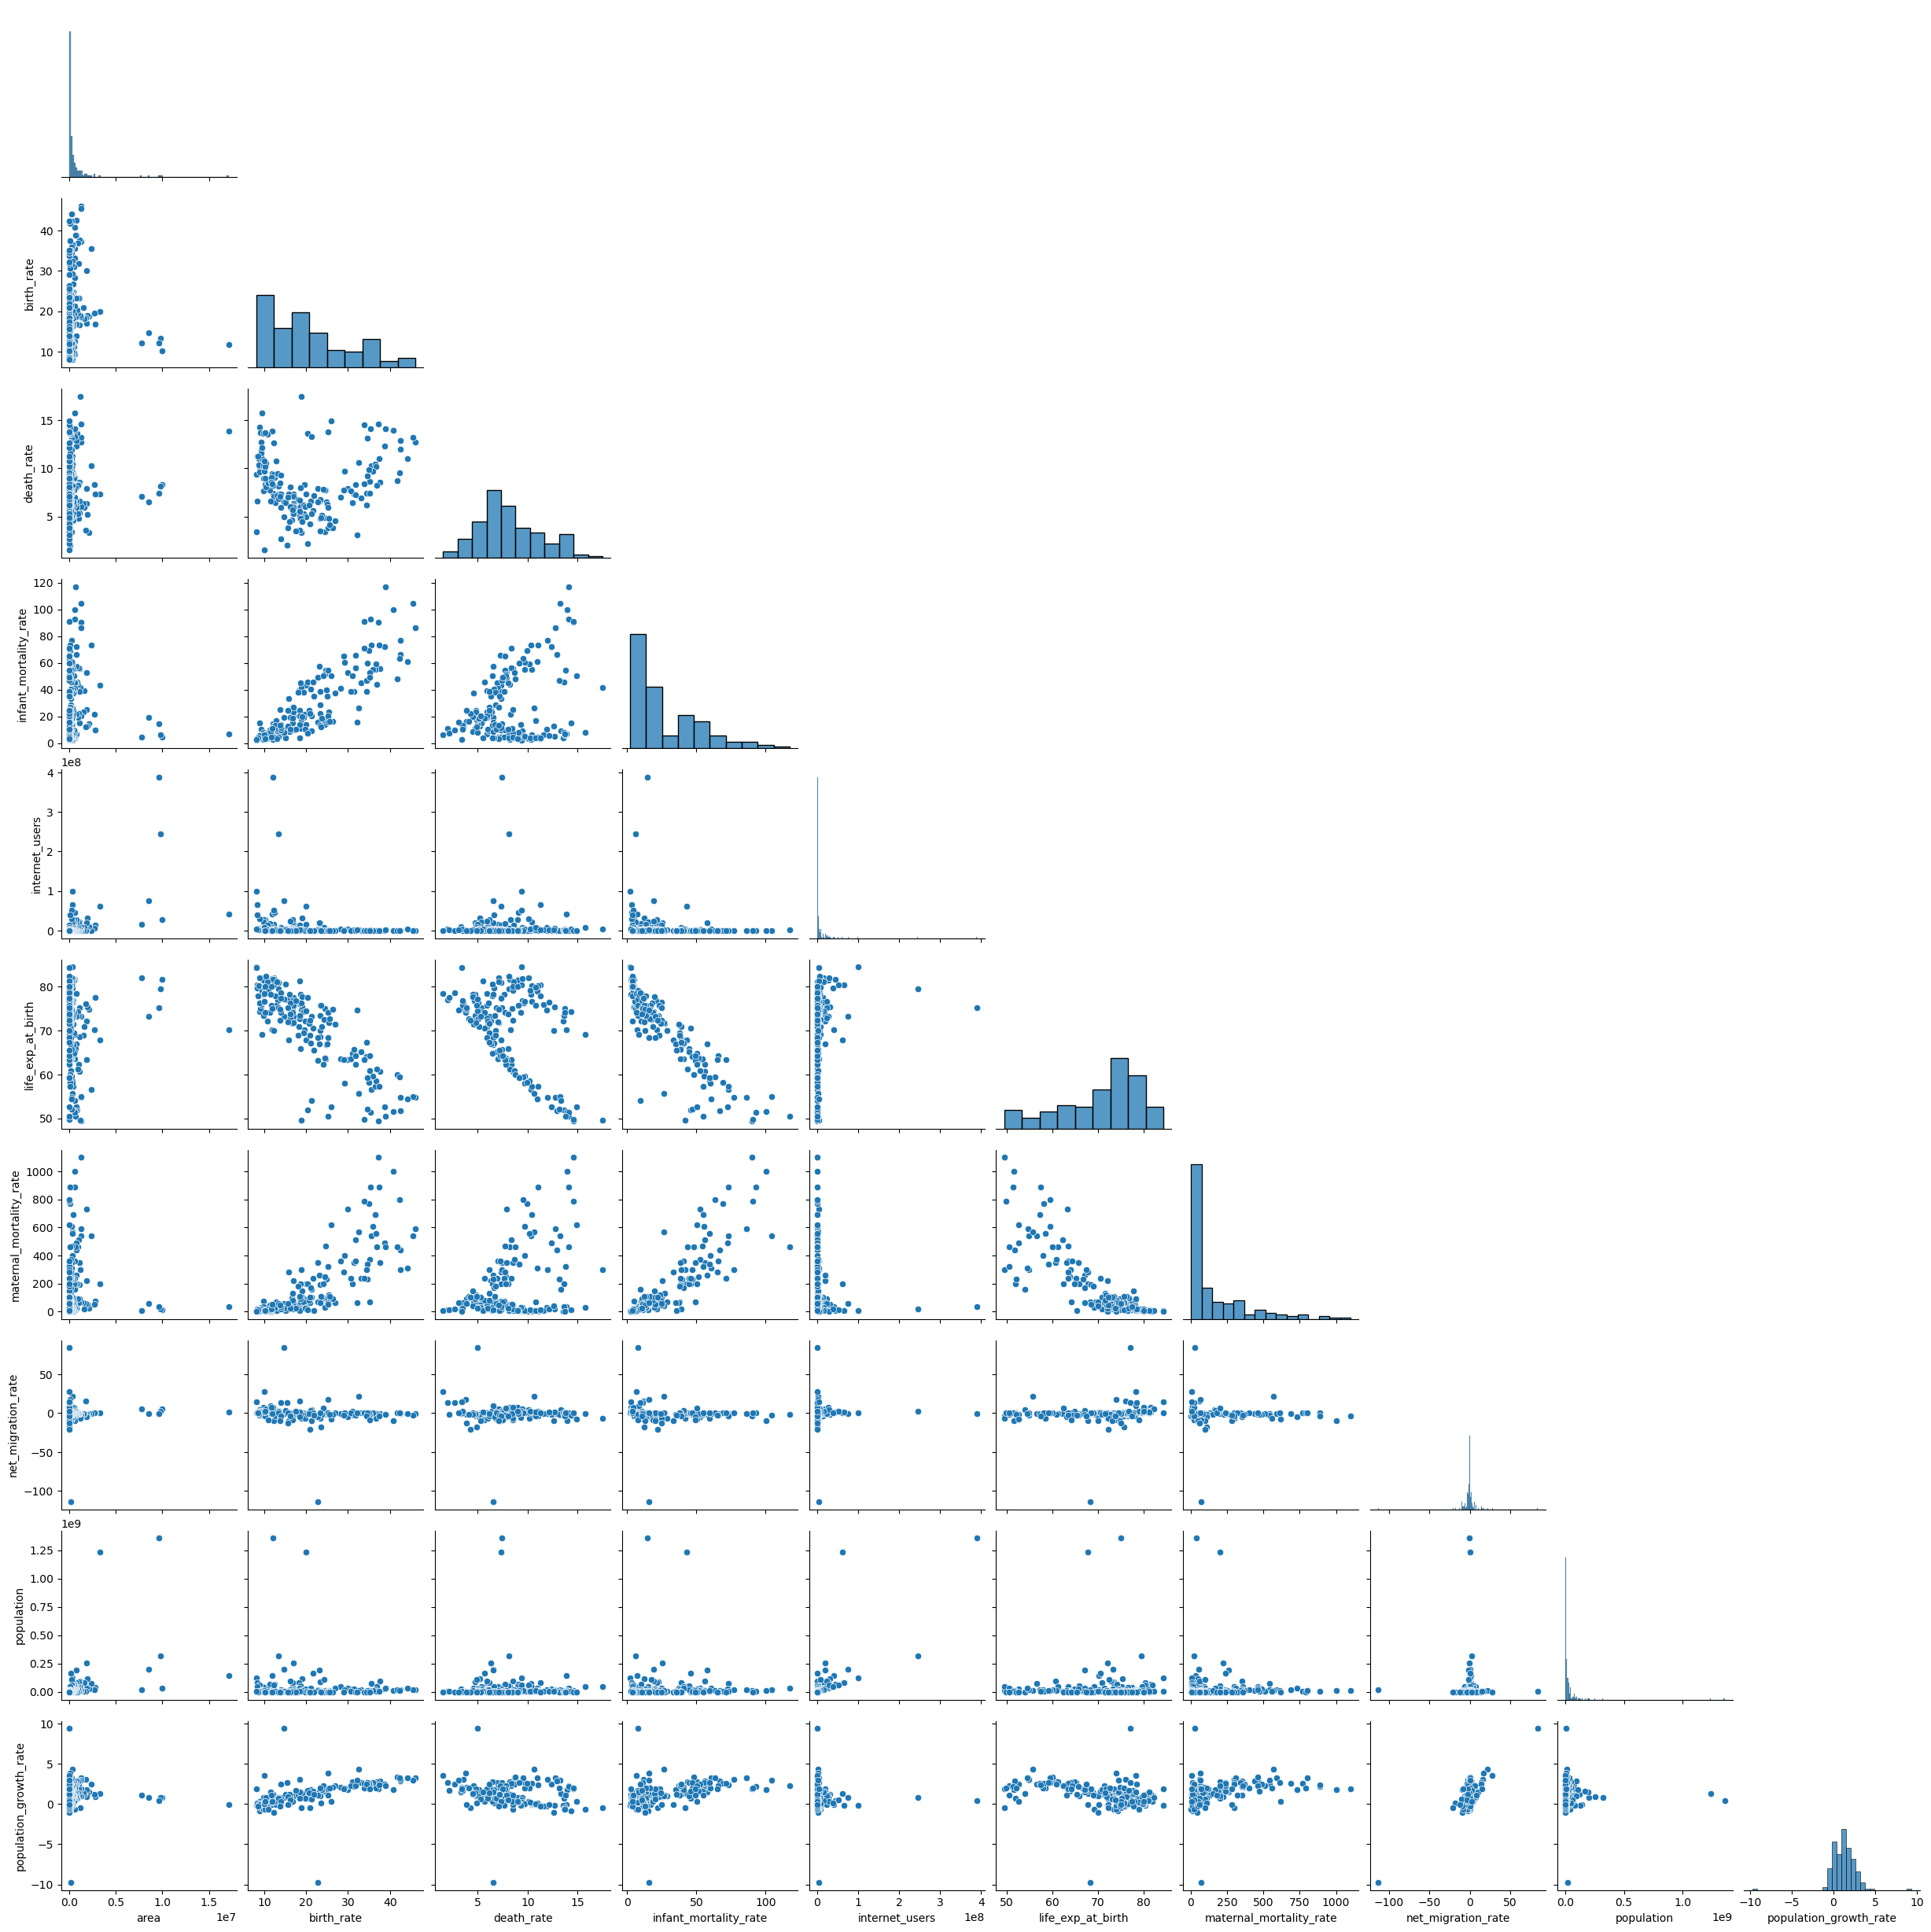

In [4]:
# Display basic information and first few rows to understand the structure
print(df.info())
print(df.head())

# Summary statistics for numerical features
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualize distribution of key numerical features
sns.pairplot(df.dropna(), corner=True)
plt.show()

## Feature Engineering for Missing Data

In [6]:
# Impute missing values across all numerical columns
imputer = SimpleImputer(strategy='mean')
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Verify imputation
print(df.isnull().sum())

country                    0
area                       0
birth_rate                 0
death_rate                 0
infant_mortality_rate      0
internet_users             0
life_exp_at_birth          0
maternal_mortality_rate    0
net_migration_rate         0
population                 0
population_growth_rate     0
dtype: int64


## Data Feature Preparation

### Create dummy variables for categorical data

In [9]:
# Convert categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

### Scale numerical data

In [11]:
# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

## Creating and Fitting Kmeans Model

### Find the optimal number of clusters

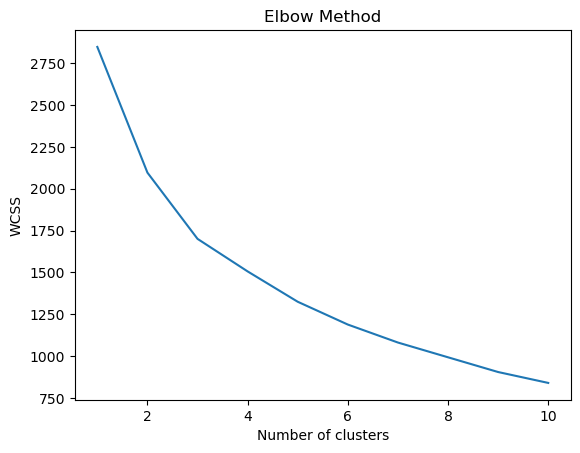

In [14]:
# Elbow method to determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.38061391163422786
For n_clusters = 3 The average silhouette_score is : 0.39867045589494027
For n_clusters = 4 The average silhouette_score is : 0.20821494431323984
For n_clusters = 5 The average silhouette_score is : 0.2025715966894651
For n_clusters = 6 The average silhouette_score is : 0.20184397865728168
For n_clusters = 7 The average silhouette_score is : 0.19593337323670204
For n_clusters = 8 The average silhouette_score is : 0.19702616455320465
For n_clusters = 9 The average silhouette_score is : 0.20208622724843747
For n_clusters = 10 The average silhouette_score is : 0.17179960879043785
The optimal number of clusters is: 3


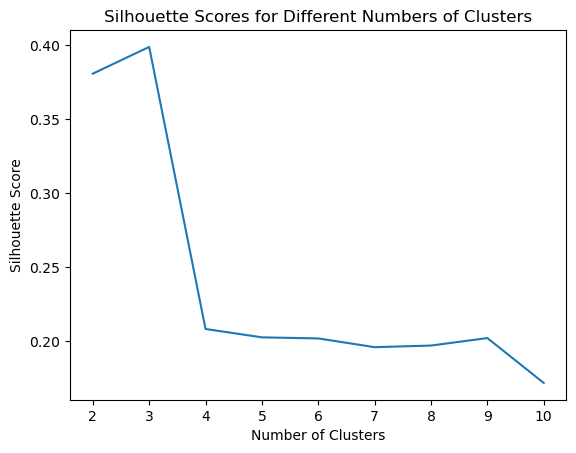

In [15]:
# Initialize range of clusters to test
range_n_clusters = list(range(2, 11))

# Initialize list to store silhouette scores
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

# Find the optimal number of clusters, based on silhouette score
optimal_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print("The optimal number of clusters is:", optimal_clusters)

plt.plot(range_n_clusters, silhouette_scores)
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Fit the k-means model with the optimal number of clusters

In [17]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(df)

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

## Model Interpretation

Based on the Silhouette Scores, the optimal number of clusters is 3, as it achieves the highest score, indicating the best balance between within-cluster similarity and between-cluster separation. This suggests that three clusters provide a clear and meaningful grouping of the data, without additional complexity that more clusters would introduce. There aren't multiple reasonable choices in this case, given that the silhouette score significantly drops for four or more clusters. The key features defining these cluster choices likely involve the dimensions that show the most variance and hence offer the most meaningful ways to differentiate between the groups.

             area  birth_rate  death_rate  infant_mortality_rate  \
Cluster                                                            
0       -0.057046   -0.408613   -0.218868              -0.427351   
1        4.172707   -0.501432   -0.093932              -0.138802   
2       -0.018424    1.556374    0.823948               1.606319   

         internet_users  life_exp_at_birth  maternal_mortality_rate  \
Cluster                                                               
0             -0.051843           0.426501                -0.359760   
1              7.371531           0.287003                -0.416813   
2             -0.215599          -1.611375                 1.368926   

         net_migration_rate  population  population_growth_rate  ...  \
Cluster                                                          ...   
0                  0.010524   -0.093395               -0.234134  ...   
1                  0.085002    7.678747               -0.209181  ...   
2              

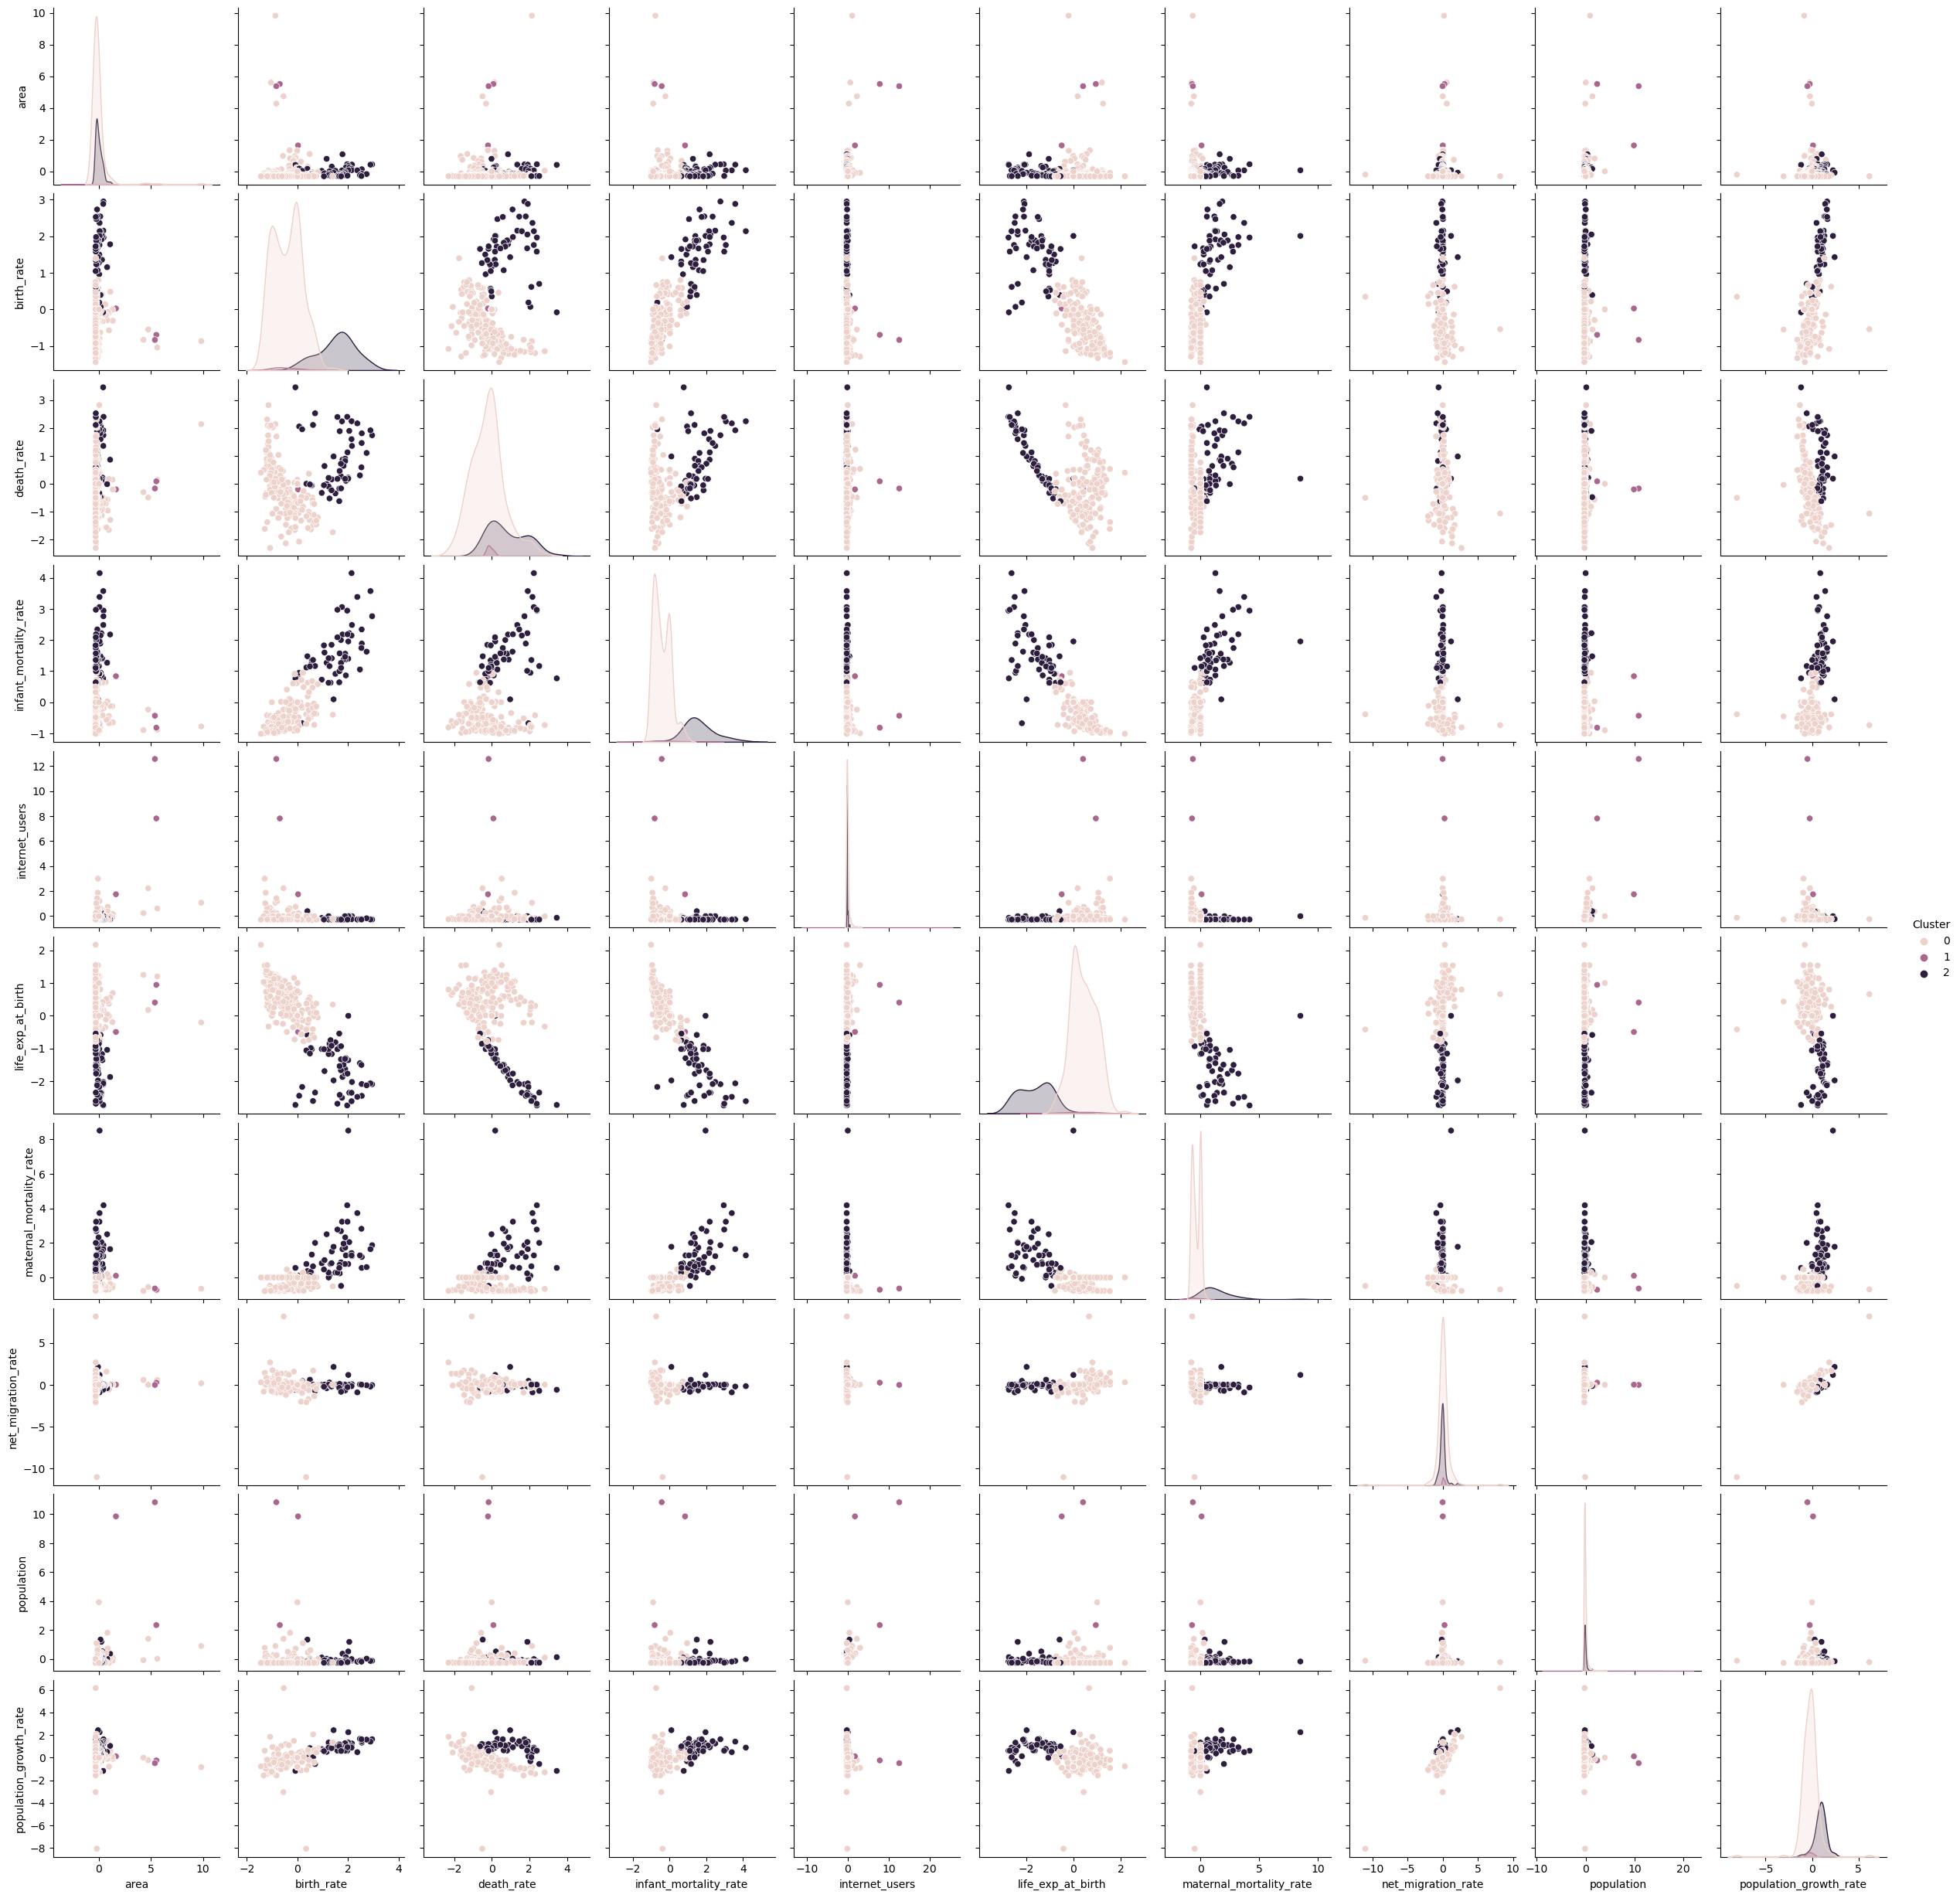

Cluster interpretations based on the central tendencies and dispersion of features within each cluster.


In [19]:
# Analyze clusters
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

# Visualizing the clusters
sns.pairplot(df, hue='Cluster', vars=numerical_cols)
plt.show()

# Interpretation
print("Cluster interpretations based on the central tendencies and dispersion of features within each cluster.")